# Privacy-Safe NetworkRetriever Demo

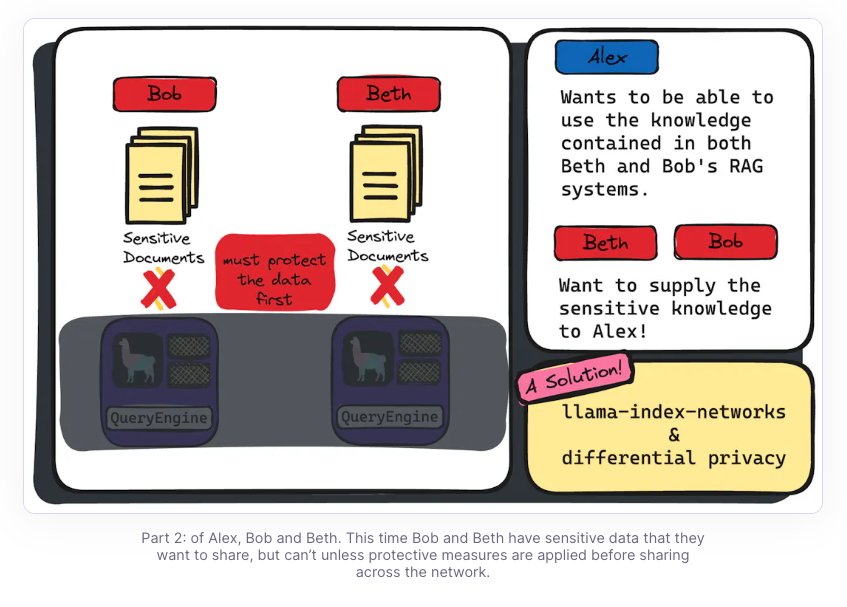

Please make sure to follow the README instructions to start up the `ContributorRetrieverService`'s that this notebook requires to be running. That is because a `NetworkRetriever` will be created here that connects to those services via `ContributorRetrieverClient`'s.

The network in this notebook is privacy safe, since the data that is being exchanged are differentially, private synthetic examples of the [Symptom2Disease](https://www.kaggle.com/datasets/niyarrbarman/symptom2disease) dataset. The synthetic dataset was created by the `DiffPrivateSimpleDatasetPack` llama-pack. For details on the dataset curation, see the demo in the Github repository for that llama-pack (found [here](https://github.com/run-llama/llama_index/tree/main/llama-index-packs/llama-index-packs-diff-private-simple-dataset/examples/symptom_2_disease)).

We created two versions of synthetic dataset, differing by the levels of privacy as defined by the parameter epsilon. See README for more details.

Privacy-safe networks such as these allow for the data collaboration of sensitive data, and thus provides a pathway for better modelling, research and the like. In this notebook, we show the advantages of being able to connect to multiple data sources, that you may otherwise not have access to except for within a privacy-safe network.

**The Situation/Task**

There are a set of symptoms (in the test set) for which we would like to query the retrievers for similar medical cases. The retrieved noders also carry <symptoms, disease-label> pair (i.e., the `text` attribute of the node are the symptoms and the `reference_label` in the node's `metadata` carries the disease-label). So, after performing retrieval we can see what potential diseases may be related to the symptoms described in the query.

For evaluation, we also have and thus use the true labels in the test set. We consider two retrieval metrics, namely: hit rate and mean reciprocal rank.

In [3]:
%pip install llama-index-postprocessor-cohere-rerank -q


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import tqdm

from llama_index.core.llama_dataset.simple import LabelledSimpleDataset
from llama_index.networks.network.retriever import NetworkRetriever
from llama_index.networks.contributor.retriever import ContributorRetrieverClient

In [3]:
import nest_asyncio

nest_asyncio.apply()

### Load Symptom2Disease TestData

This test set represents real observations (i.e. not synthetically generated) from the Symptom2Disease dataset. The original dataset was split into a train and test split, where only the train dataset was used to create the differentially private synthetic data examples.

In [4]:
test_dataset = LabelledSimpleDataset.from_json("./networks_data/symptom_2_disease_test.json")

In [5]:
test_dataset.to_pandas()[:5]

,reference_label,text,text_by
0,Cervical spondylosis,"I've been battling with back pain, a dry cough...",human
1,Common Cold,"My neck is swollen, and I'm exhausted. My thro...",human
2,Bronchial Asthma,I've been having a tough time with this consta...,human
3,Dimorphic Hemorrhoids,"Recently, I've been having a lot of difficulty...",human
4,Common Cold,"I keep sneezing, and my eyes don't quit drippi...",human


### NetworkRetriever

Create the `NetworkRetriever` that connects to both `ContributorRetrieverServices`

In [6]:
# setup ContributorRetrieverClients to connect to ContributorRetrieverServices
contributors = [
    ContributorRetrieverClient.from_config_file(
        env_file=f"./networks_data/client-env-files/.env.contributor_{ix}.client"
    )
    for ix in range(1, 3)
]

#### Optional Reranker

We add a reranker to rerank the nodes that come back from each of the Contributors.

In [7]:
from llama_index.postprocessor.cohere_rerank import CohereRerank

reranker = CohereRerank(top_n=5)

In [8]:
network_retriever = NetworkRetriever(
    contributors=contributors, node_postprocessors=[reranker]
)

### NetworkRetriever Results

In [9]:
(test_dataset[0].text, test_dataset[0].reference_label)

("I've been battling with back pain, a dry cough, and limb weakness. I've been feeling dizzy and unstable on my feet, and my neck hurts.",
 'Cervical spondylosis')

In [10]:
relevant_examples = await network_retriever.aretrieve(test_dataset[0].text)

In [11]:
[r.metadata["reference_label"] for r in relevant_examples]

['Bronchial Asthma',
 'Jaundice',
 'Bronchial Asthma',
 'Cervical spondylosis',
 'Cervical spondylosis']

Run through all the test examples to get the retrieved nodes using `NetworkRetriever`.

In [10]:
network_retrievals = []
for example in tqdm.tqdm(test_dataset[:]):
    network_retrievals.append(await network_retriever.aretrieve(example.text))

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [01:21<00:00,  2.95it/s]


### Contributor1 Retriever Results

For comparisons sake, we do the same as above but for only a retriever that has access to Contributor 1's data.

In [11]:
contributor1_retriever = NetworkRetriever(contributors=contributors[:1])
contributor1_retrievals = []
for example in tqdm.tqdm(test_dataset[:]):
    contributor1_retrievals.append(await contributor1_retriever.aretrieve(example.text))

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:53<00:00,  4.46it/s]


### Contributor2 Retriever Results

And, similarly for Contributor 2.

In [12]:
contributor2_retriever = NetworkRetriever(contributors=contributors[1:2])
contributor2_retrievals = []
for example in tqdm.tqdm(test_dataset[:]):
    contributor2_retrievals.append(await contributor2_retriever.aretrieve(example.text))

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:55<00:00,  4.30it/s]


### Evaluations

We compute the hit rate and mean reciprocal rank scores on the retrievals using the three retrievers.

In [13]:
from typing import List
from llama_index.core.schema import NodeWithScore


def compute_hit(retrieved_nodes: List[NodeWithScore], expected_label: str):
    return any(r.metadata["reference_label"] == expected_label for r in retrieved_nodes)


def compute_reciprocal_rank(retrieved_nodes: List[NodeWithScore], expected_label: str):
    for i, r in enumerate(retrieved_nodes):
        if r.metadata["reference_label"] == expected_label:
            return 1.0 / (i + 1)
    return 0

#### NetworkRetriever

In [14]:
network_retriver_hits = [
    compute_hit(r, ex.reference_label)
    for r, ex in zip(network_retrievals, test_dataset.examples)
]
network_retriver_reciprocal_ranks = [
    compute_reciprocal_rank(r, ex.reference_label)
    for r, ex in zip(network_retrievals, test_dataset.examples)
]

#### Contributor 1

In [15]:
contributor1_retriever_hits = [
    compute_hit(r, ex.reference_label)
    for r, ex in zip(contributor1_retrievals, test_dataset.examples)
]
contributor1_retriever_reciprocal_ranks = [
    compute_reciprocal_rank(r, ex.reference_label)
    for r, ex in zip(contributor1_retrievals, test_dataset.examples)
]

#### Contributor 2

In [16]:
contributor2_retriever_hits = [
    compute_hit(r, ex.reference_label)
    for r, ex in zip(contributor2_retrievals, test_dataset.examples)
]
contributor2_retriever_reciprocal_ranks = [
    compute_reciprocal_rank(r, ex.reference_label)
    for r, ex in zip(contributor2_retrievals, test_dataset.examples)
]

#### Summary Report

In [17]:
import pandas as pd

num_examples = len(test_dataset.examples)
summary_data = {
    "retriever": ["network", "contributor1", "contributor2"],
    "hit rate": [
        sum(network_retriver_hits) / num_examples,
        sum(contributor1_retriever_hits) / num_examples,
        sum(contributor2_retriever_hits) / num_examples,
    ],
    "mean reciprocal rank": [
        sum(network_retriver_reciprocal_ranks) / num_examples,
        sum(contributor1_retriever_reciprocal_ranks) / num_examples,
        sum(contributor2_retriever_reciprocal_ranks) / num_examples,
    ],
}
summary_df = pd.DataFrame(summary_data)
summary_df

,retriever,hit rate,mean reciprocal rank
0,network,0.808333,0.589861
1,contributor1,0.425000,0.355486
2,contributor2,0.462500,0.410417


In summary, we make the following observations:

1. The `NetworkRetriever` outperforms the individual `Contributor` retriever. This makes sense because we split up the data into two disjoint sets and assigned them to Contributors 1 and 2. In other words, each contributor has their own unique subset of diseases. Therefore, having a network connect to both of these datasets mean that you have access to more records of diseases than you'd otherwise have with only using one of these contributors.
2. The synthetic data, still maintains some utility in this toy example. We see this because the synthetic data does still closely align with the symptoms of the test set.

**Important Note**

This example was merely a toy example, showing the potential in using LLMs to generate synthetic, privacy safe observations. The tradeoff between privacy and accuracy must be carefully considered for each individual case. Adding too much privacy (i.e., noise) may render the synthetic observations useless (and in this case for example, may lead to the wrong records being retrieved for something as delicate as potentially diagnosing a set of symptoms.)